# CS 480E/580E: Numerical Algorithms

Due Date: 06/10/2025

This is a warmup assignment to reinforce the math review. We will write some numerical code.

## Write your name and bu ID

Name: Obadiah Smolenski

BU ID: osmolenski

In [29]:
from typing import Optional, Tuple, Callable, List

Place additional imports below

In [30]:
import numpy as np
from scipy.special import gamma

## Numerical Inversion by Binary Search [16 points]

For this part, you are to write a function named `invert` that has two required parameters and one optional parameter d. The required parameters are another function f(x) and a y value. Your function should return the x value such that f(x) = y. The function is guaranteed to be non-decreasing, i.e., the derivative is always 0 or positive. If a 3rd argument is given, it will be a tuple (if using Python) representing an interval where the function is guaranteed to be non-decreasing. Otherwise, you may assume that the function is everywhere non-decreasing.

Make sure your function always terminates.


You will then apply your invert function to the two functions below.

In [31]:
def derivative_1d(func: Callable, x: float, epsilon: float = 1e-10) -> float:
    return (func(x + epsilon) - func(x - epsilon)) / (2 * epsilon)

def invert(func: Callable, y_value: float, d: Optional[Tuple[float, float]] = None, epsilon: float = 1e-15) -> float:
    def f_diff(x: float) -> float:
        return func(x) - y_value

    if d is None:
        x = y_value
        diff = f_diff(x)
        prev_x = y_value
        while True:
            prev_x = x
            if diff > 0:
                x -= derivative_1d(func, x, epsilon)
            else:
                x += derivative_1d(func, x, epsilon)

            diff = f_diff(x)
            if np.sign(f_diff(prev_x)) != np.sign(diff):
                d = (min(x, prev_x), max(x, prev_x))
                break
            elif diff == f_diff(prev_x):
                d = (x - .1, x + .1)
                break

    a, b = d
    mid = (b + a) / 2

    while abs(b - a) > epsilon:
        if f_diff(mid) == 0:
            return mid
        elif f_diff(mid) > 0:
            b = mid
        else:
            a = mid

        mid = (b + a) / 2

    return mid

print(invert(lambda x: x*x, 2, (0, 2.0)))
print(invert(lambda x: 2*x, 2))

1.4142135623730954
1.0000000000000002


## Transcendental Functions [8 pts]

Test your invert function with this function:

$$
f(x) = xe^x + x
$$

**Write** a test to make sure that your invert routine is able to invert the function everywhere. We leave it up to you to think about how to design and implement such a test.

In [32]:
def f(x: float) -> float:
    return x * (np.e ** x) + x

epsilon = 1e-14

assert(abs(invert(f, 0) - 0) < epsilon)
assert(abs(invert(f, 1 + 1*(np.e**1)) - 1) < epsilon)
assert(abs(invert(f, (-1 - 1/np.e)) - (-1)) < epsilon)
assert(abs(invert(f, 2 + 2*(np.e**2), epsilon=epsilon) - 2) < epsilon)
assert(abs(invert(f, 3 + 3*(np.e**3), epsilon=epsilon) - 3) < epsilon)

## Gamma Function [8 points]
The gamma function is component of many probability distribution functions and has a wide range of applications in probability, statistics, and physics. The gamma function is defined as an improper integral:

$$
\Gamma(x) = ∫_0^\infty t^{x-1}e^{-t}dt
$$

**Write** a test to verify your `invert` function is able to invert the Gamma function in the domain, `d=(1.5, 16)`. You may use the gamma function defined in [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html).

In [33]:
epsilon = 1e-10
assert(abs(invert(gamma, 1.7, (1.5, 16), epsilon) - 2.8164979495219) < epsilon)
assert(abs(invert(gamma, 2, (1.5, 16), epsilon) - 3) < epsilon)
assert(abs(invert(gamma, 6, (1.5, 16), epsilon) - 4) < epsilon)

#  Numerical Integration [7 points]

A large class of continuous functions do not have closed-form solutions for their antiderivatives. This is also the case for any function you approximate using a neural network.

In this case, the definite integral over a range can be computed numerically. Write a function `integrate` that has two parameters: another function, `func` and a tuple representing the range of integration. `func` has the signature `func(float) -> float`.

Your function should return the definite integral of the function f(x), computed over the given range.

In [34]:
def integrate(func: Callable[[float], float], range_start: float, range_end: float) -> float:
    rng = np.random.default_rng()
    num_samples = int(1e8)
    heights = np.sum(func(rng.uniform(range_start, range_end, num_samples)))

    return (range_end - range_start) * (1 / num_samples) * heights

In the following cell define the function below, and compute the definite integral numerically using your `integrate` function.

$$
\int_{-1}^{1}\frac{sin(x)}{x}dx
$$

You may use Monte Carlo or other sampling-based methods, as long as the program terminates in a reasonable amount of time (less than a couple of minutes). Your function should return the integral value with as high a precision as possible.



In [35]:
def g(x: float) -> float:
    return np.sin(x) / x

# should be 1.89217, from wolfram alpha
print(integrate(g, -1, 1))

1.89214813265574


# Gradient Descent [39 points]

For this part, you will write a gradient descent optimizer and use it to minimize some functions. In the below, we’ll call the function to be optimized f. Write a function opt with four parameters: a function grad(p), a tuple start giving the starting point of the optimization, the step size step, and a maximum gradient length to be used for gradient clipping. The function grad(p) should accept a point p as a tuple and returns a tuple giving the gradient of f at p.

Your function opt should return an array of tuples consisting of the sequence of points where the gradient is evaluated, starting from the start point. The last element of the returned array should be the point that minimizes f. The point may be a local mininum.


A common problem in gradient descent is that the actual change to the current point depends on the gradient. If the gradient is very large, that can cause "overshooting" the minimum. One technique to address this issue is "gradient clipping"--simply clip the gradient to some upper bound.


Note: Make sure your function always terminates. You set maximum iterations, keep track of time elapsed, or identify if the calculations have diverged.

Place your function in a separate cell. You will then apply your opt function to two functions below.


In [36]:
def opt(grad: Callable[[Tuple[float, ...]], Tuple[float, ...]],
        start: Tuple[float, ...],
        step: float,
        max_grad_length: float) -> Tuple[Tuple[float, ...], ...]:
        vis = []
        max_iterations = int(1e3)
        for _ in range(max_iterations):
            start = np.array(start)
            xs_g = np.array(grad(start))

            mag = np.sqrt(np.sum(xs_g ** 2))
            if mag > max_grad_length:
                xs_g *= max_grad_length / mag
            start -= xs_g
            vis.append(start)

        return vis

## Three-Hump Camel Function [15 points]

The [three-hump camel](https://www.sfu.ca/~ssurjano/camel3.html) function is a two-dimensional function often used to benchmark optimization methods. It has multiple extrema. The three-hump camel function is defined as:

$$
f(x_1, x_2) = 2x_1^2-1.05x_1^4+\frac{x_1^6}{6} + x_1x_2 + x_2^2
$$
where, $-5 \leq x_i \leq 5 $, for $i = 1,2$.



**Implement** the function `thcf` in the following cell that takes in $p=(x_1,x_2)$ as an input.

In [37]:
def thcf(p: Tuple[float, float]) -> float:
    x1, x2 = p
    return 2 * (x1 ** 2) - 1.05 * (x1 ** 4) + (x1 ** 6) / 6 + x1 * x2 + (x2 ** 2)


**Implement** the gradient funcion, `thcf_grad` that accepts a point and returns the gradient of that point, both as tuples.


In [38]:
def thcf_grad(p: Tuple[float, float]) -> Tuple[float, float]:
    x1, x2 = p
    d_dx1 = 4 * x1 - 4.2 * (x1 ** 3) + (x1 ** 5) + x2
    d_dx2 = x1 + 2 * x2
    return (d_dx1, d_dx2)

**Write** a test in the following cell that checks using a finite difference that your thcf_grad function is implemented correctly. It should use randomization of the point at which to check the gradient, and allow running for any number of checks. It should be as convincing as possible.

In [53]:
def derivative_2d(func: Callable[[Tuple[float, float]], float], p: Tuple[float, float], epsilon: float = 1e-6) -> Tuple[float, float]:
    x, y = p
    return ((func((x + epsilon, y)) - func((x - epsilon, y))) / (2 * epsilon), (func((x, y + epsilon)) - func((x, y - epsilon))) / (2 * epsilon))

rng = np.random.default_rng()
num_samples = int(1e5)
epsilon = 1e-6

for _ in range(num_samples):
    x, y = rng.uniform(-5, 5, 2)

    x_g, y_g = thcf_grad((x, y))
    x_fd, y_fd = derivative_2d(thcf, (x, y))

    # assert(abs(x_g - x_fd) < epsilon)
    if abs(x_g - x_fd) >= epsilon:
        print(f"|{x_g} - {x_fd} = {abs(x_g - x_fd)}")
    # assert(abs(y_g - y_fd) < epsilon)
    if abs(y_g - y_fd) >= epsilon:
        print(f"|{y_g} - {y_fd} = {abs(y_g - y_fd)}")

**Write** a program that find the global minimum, possibly using multiple runs of your opt function. Your code should not have a hard-coded starting point.


In [40]:
num_samples = int(1e2)

mins = []
for _ in range(num_samples):
    p = rng.uniform(-5, 5, 2)
    mins.append(opt(thcf_grad, p, 1e-3, 1e-3))
    # mins += opt(thcf_grad, p, 1e-2, 10)

min_path = min(mins,key=lambda l: thcf(l[-1]))
print(thcf(min_path[-1]))

6.394585061907866e-07


**Write** visualization code and generate a surface plot or contour plot of the function, showing the path of the gradient descent that found the global minimum. You can use the [matplotlib](https://matplotlib.org/) library.

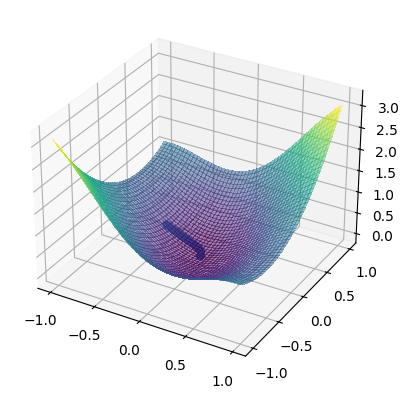

In [41]:
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(X, Y)
Z = thcf((X, Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False, alpha=0.5)
xs, ys = (np.array([x for (x, _) in min_path]), np.array([y for _, y in min_path]))
ax.scatter(xs, ys, thcf((xs, ys)))

plt.show()

## 2-D Shubert Function [24 points]
The [Shubert function](https://www.sfu.ca/~ssurjano/shubert.html) is an N-dimensional function also often used to benchmark optimization methods. It also has many local and global minima that are irregularly distributed in the domain. The 2-D Shubert function is defined as:

$$
f(x_1,x_2) = \left(\sum_{i=1}^5 i \cos\left[(i+1)x_1+i\right]\right) \left(\sum_{i=1}^5 i \cos\left[(i+1)x_2+i\right]\right)
$$
where,
$-10 \leq x_1 \leq 10$, for $i=1,2$.


**Implement** the function `sf` with a single tuple parameter `p`, giving two float coordinates `x_1, x_2` to evaluate the function at that point.

In [42]:
def sf(p: Tuple[float, float]) -> float:
    x1, x2 = p
    res_1 = 0
    for i in range(1, 6):
        res_1 += i * np.cos((i + 1) * x1 + i)
    res_2 = 0
    for i in range(1, 6):
        res_2 += i * np.cos((i + 1) * x2 + i)

    return res_1 * res_2

**Implement** the gradient function, sf_grad that accepts a point and returns the gradient of that point, both as tuples.

In [55]:
def sf_grad(p: Tuple[float, float]) -> Tuple[float, float]:
    x1, x2 = p
    g = 0
    h = 0
    g_grad = 0
    h_grad = 0
    for i in range(1, 6):
        g += i * np.cos((i + 1) * x1 + i)
        g_grad += i * (i + 1) * -np.sin((i + 1) * x2 + i)
        h += i * np.cos((i + 1) * x1 + i)
        h_grad += i * (i + 1) * -np.sin((i + 1) * x2 + i)
    return derivative_2d(sf, p)

num_samples = int(1e4)
epsilon = 1e-6

for _ in range(num_samples):
    x, y = rng.uniform(-10, 10, 2)

    x_g, y_g = sf_grad((x, y))
    x_fd, y_fd = derivative_2d(sf, (x, y))

    # assert(abs(x_g - x_fd) < epsilon)
    if abs(x_g - x_fd) >= epsilon:
        print(f"|{x_g} - {x_fd} = {abs(x_g - x_fd)}")
    # assert(abs(y_g - y_fd) < epsilon)
    if abs(y_g - y_fd) >= epsilon:
        print(f"|{y_g} - {y_fd} = {abs(y_g - y_fd)}")

**Write** a program that find the global minimum, possibly using multiple runs of your opt function. Your code should not have a hard-coded starting point.

In [56]:
num_samples = int(1e2)

mins = []
for _ in range(num_samples):
    p = rng.uniform(-5, 5, 2)
    mins.append(opt(sf_grad, p, 1e-3, 1e-3))

min_path = min(mins,key=lambda l: sf(l[-1]))
print(sf(min_path[-1]))

-186.73044812441748


**Write** visualization code and generate a surface plot or contour plot of the function, showing the path of the gradient descent that found the global minimum. You can use the [matplotlib](https://matplotlib.org/) library.

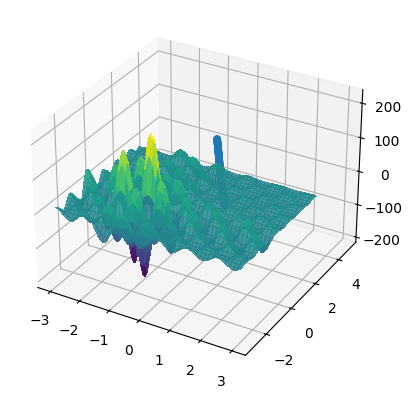

In [57]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.arange(-3, 3, 0.01)
Y = np.arange(-3, 3, 0.01)
X, Y = np.meshgrid(X, Y)
Z = sf((X, Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False, alpha=0.85)
xs, ys = (np.array([x for (x, _) in min_path]), np.array([y for _, y in min_path]))
ax.scatter(xs, ys, sf((xs, ys)))

plt.show()

# Random Variates

Generating samples from complicated distributions is the cornerstone of generative modeling. While it is simple to sample from uniform or normal distribution, we must use other techniques for complex distributions.


## Rejection Sampling [15 points]

Rejection sampling is a technique that allows use to sample from a probability distribution F, with a probability distribution function (PDF), f(x), by sampling from a simpler proposal distribution G and rejecting values >f(x)

The function $sin(x)^2$ can be used to define a PDF over $x\in[0, \pi]$. However, since PDFs must be normalized. The area under the curve must equal 1 because the total probablity must sum to 1.  This can be done by simply integrating function over the domain, and dividing it by the value of the definite integral to obtain the actual PDF.

In the following markdown cell, find the correct PDF $sin(x)^2$ by normalizing it. You may use tools such as Mathematica if you wish, but explain how you did it.

$A = \int_0^\pi{\sin^2(x)\,dx} = \frac{\pi}{2} \\
PDF_{sin^2}(x) = \frac{1}{A} \sin^2(x) = \frac{2}{\pi}\sin^2(x)$

**Write** a function named pdf_sin2(n) that generates n variates according to the PDF, and returns them in a list. Use rejection sampling. You can use a simple uniform distribution as your proposal distribution. If you wish, you may also use a proposal distribution that more closely envelopes (bounds) the target distribution. A different point must be generated each time it is called, but it is okay if the same sequence is generated. (No need to seed.)

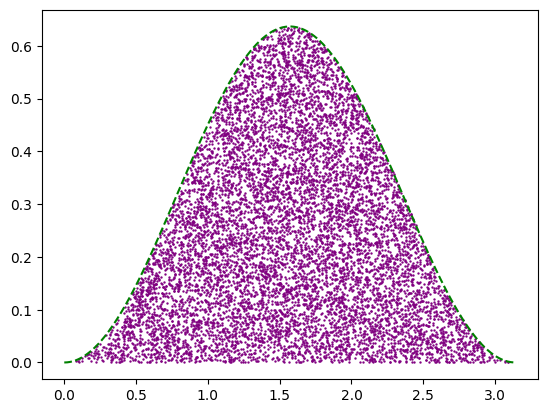

In [46]:
def normalized_sin2(x: float) -> float:
    return 2/np.pi * (np.sin(x) ** 2)


def pdf_sin2(n: int) -> List[Tuple[float, float]]:
    # simpler proposal distribution
    def proposal_pdf(x: float) -> float:
        return 2/np.pi
    ret = []
    for _ in range(n):
        x = rng.uniform(0, np.pi)
        y = rng.uniform(0, proposal_pdf(x))
        while y > normalized_sin2(x):
            x = rng.uniform(0, np.pi)
            y = rng.uniform(0, proposal_pdf(x))

        ret.append((x, y))

    return ret


samples = pdf_sin2(int(1e4))
xs = [x for x, _ in samples]
ys = [y for _, y in samples]

fig, ax = plt.subplots()

X = np.arange(0, np.pi, 0.01)
PDF = normalized_sin2(X)

ax.plot(X, PDF, color='green', linestyle='dashed')
ax.scatter(xs, ys, marker='o', color='purple', s=0.5)

plt.show()

**Write** code to programmatically convince us that you have done it correctly. You should not try to prove it mathematically, but rather do something like generate a histogram of samples from your pdf_sin2 function, and plot it against the actual PDF.

## Uniform Variates in the Unit Disk [23 points]

A possible way to generate uniform samples with a 2D disk is to first generate an $x$ in the interval going across the middle of the disk, and then a $y$ in the vertical line at the $x$ that is within the disk.

In other words, first generate x uniformly between $[-1,1]$. Draw the chord between the two points on the that have the same x value $(x, y1)$ and $(x, y2)$. Then uniformly sample $y$ between $(y1, y2)$ to get the point $(x,y)$ within the disk.

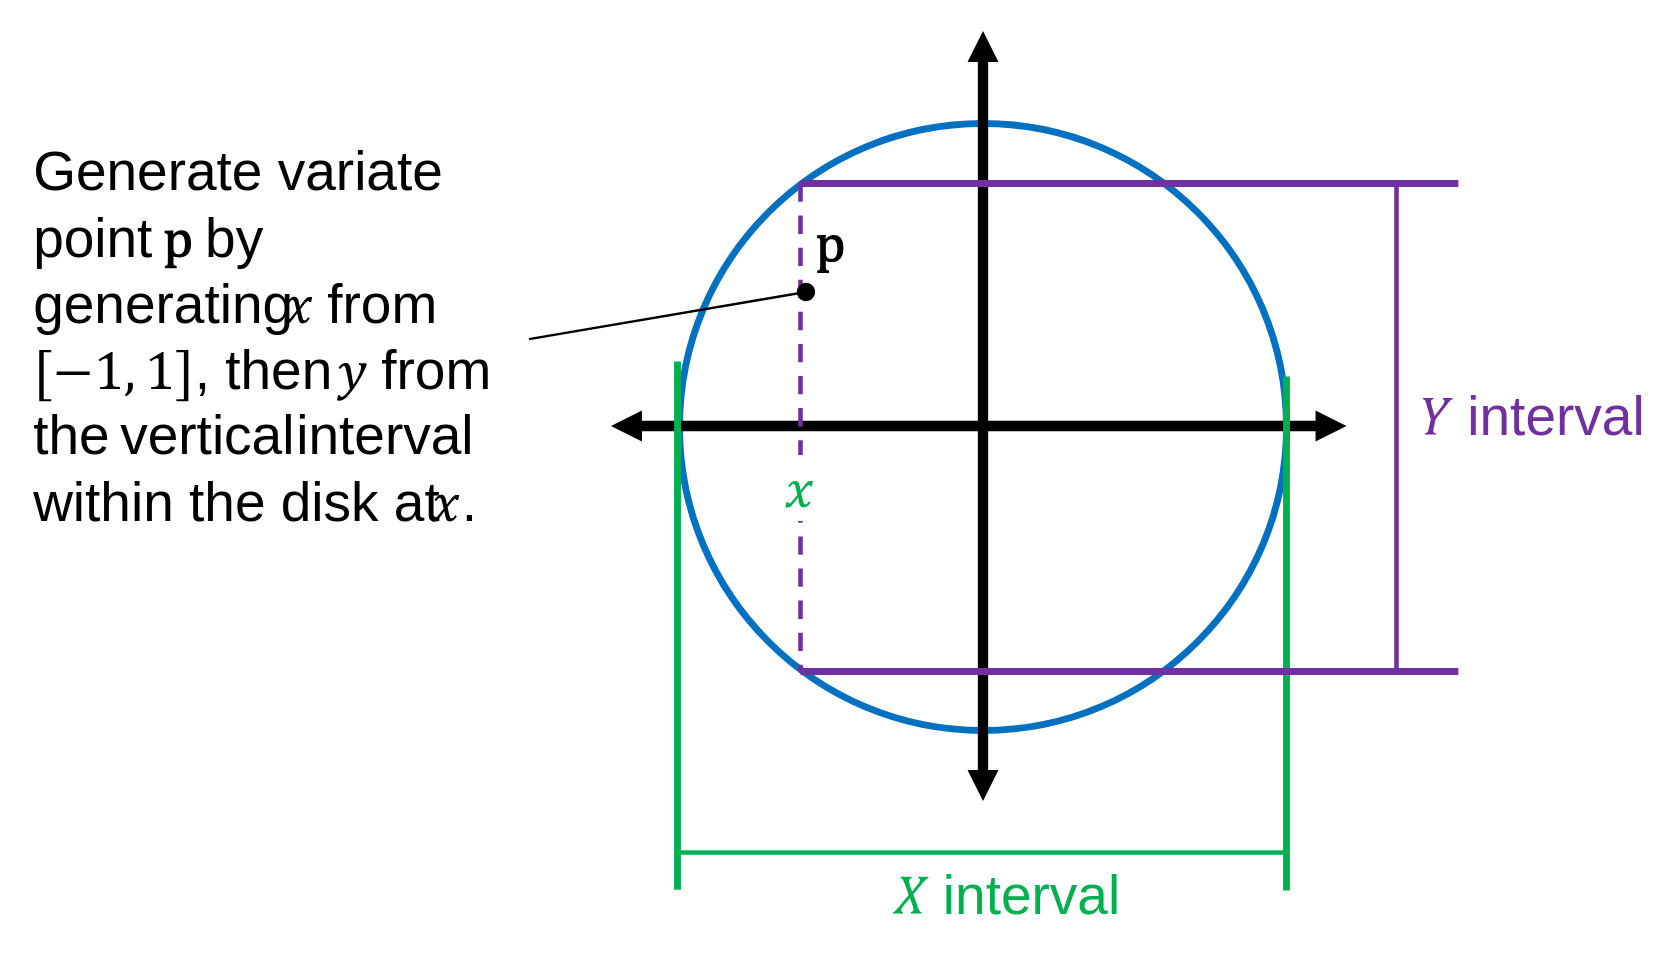

This will lead to a non-uniform distribution, however:

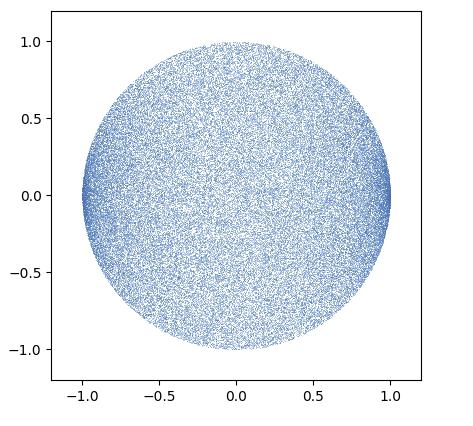

The non-uniformity can be corrected by generaing the x-coordinates non-uniformly to compensate for the non-uniformity.


In the following Markdown cell, explain how you corrected the $x$ distribution.

 You may use tools such as Mathematica if you wish, but explain how you did it. You may include LaTeX in a Markdown cell by enclosing it in \\$ characters, like \\$\sin(x)^x\\$.

$PDF_x = \frac{2}{\pi} \sqrt{1 - x^2}$ (proportional to chord length) \\
$CDF_x = \int{PDF_x\,dx} = \frac{2}{\pi}\left[\frac{1}{2}x\sqrt{1 - x^2} - \arctan\left(\frac{\sqrt{1 - x^2}}{x + 1}\right)\right] + C = \frac{1}{\pi}x\sqrt{1 - x^2} - \frac{2}{\pi}\arctan\left(\frac{\sqrt{1 - x^2}}{x + 1}\right) + 1 \\
CDF_x(-1) = 0,\ CDF(1) = 1$

**Write** a function named disk_sample(n) that generates n points sampled uniformly within the unit disk and returns them in a list. Use the inverse CDF method. A different point must be generated each time it is called, but it is okay if the same sequence is generated. (No need to seed.)

In [81]:
def normalized_half_circle_integral(x: float) -> float:
    return 1/np.pi * x * np.sqrt(1 - x ** 2) - 2/np.pi * np.arctan(np.sqrt(1 - x ** 2) / (x + 1)) + 1


def disk_sample(n: int) -> List[Tuple[float, float]]:
    ret = []
    for _ in range(n):
        # x, _ = pdf_half_circle(1)[0]
        u = rng.uniform(0, 1)
        x = invert(normalized_half_circle_integral, u, (-1, 1))
        y = rng.uniform(-np.sqrt(1 - x ** 2), np.sqrt(1 - x ** 2))
        ret.append((x, y))

    return ret

**Write** code to programmatically convince us that you have done it correctly. You should not try to prove it mathematically, but rather do something like generate a histogram of samples from your `disk_sample` function, and plot it against the actual PDF.

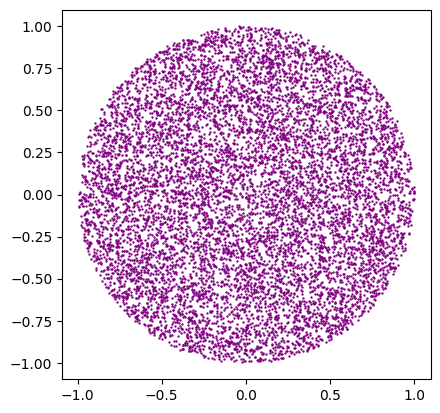

In [86]:
samples = disk_sample(int(1e4))
xs = [x for x, _ in samples]
ys = [y for _, y in samples]

fig, ax = plt.subplots()

X = np.arange(-1, 1, 0.01)

ax.scatter(xs, ys, color='purple', s=0.5)

plt.gca().set_aspect('equal')
plt.show()